# Setup

In [1]:
!pip install datasets ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 977.1/977.1 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from pathlib import Path

In [18]:
def create_dirs():
    current_dir = Path.cwd()

    subdirs = [current_dir / name for name in ("saved_models",)]

    for subdir in subdirs:
        if not subdir.is_dir():
            print(f"Directory '{subdir}' not found. Creating it...")
            subdir.mkdir(parents=True)
            print(f"Created!")

def download_model():
    import requests
    import zipfile
    import os
    from time import sleep
    import tarfile

    url = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz"
    # download model from Dropbox
    try:
        os.system(f"wget -O saved_model.zip {url}")
    except Exception as e:
        print(f"Exception occurred: {e}.")
        if (Path.is_file("saved_model.zip")):
            print("Deleting partially downloaded file...")
            os.remove("saved_model.zip")

    sleep(10)
    with tarfile.open("saved_model.zip", "r:gz") as tar_ref:
        tar_ref.extractall(model_base_dir)

    os.remove("saved_model.zip")

def setup():
    create_dirs()

    if not model_base_dir.exists() or not any(model_base_dir.iterdir()):
        print("Model not found. Downloading it...")
        download_model()
        print("Downloaded!")

def remove_setup():
    import shutil
    if model_base_dir.exists():
        shutil.rmtree(model_base_dir)
        print(f"Removed directory: {model_base_dir}")
    else:
        print(f"Directory {model_base_dir} does not exist. Nothing to remove.")

model_base_dir = Path.cwd() / "saved_models" / "640"
load_model_dir = model_base_dir / "ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8" / "saved_model"

# remove setup
remove_setup()

setup()

Removed directory: /content/saved_models/640
Model not found. Downloading it...
Downloaded!


# Execution

In [19]:
import numpy as np
from PIL import Image
import tensorflow as tf
import numpy as np

# Cargar modelo
detect_fn = tf.saved_model.load(load_model_dir)

In [20]:

from datasets import load_dataset

raw_dataset = load_dataset("ilsilfverskiold/traffic-camera-norway-images")


In [21]:
# Cargar imagen de prueba
image = raw_dataset['train'][12]['image']

# Preprocesar imagen
input_tensor = tf.convert_to_tensor(image)
input_tensor = input_tensor[tf.newaxis, ...]

# Ejecutar inferencia
detections = detect_fn(input_tensor)

tf.Tensor(
[          3           3           6           6           8           3           8           8           3           8           6           3           3           8           3           8           3           8           8           3           8           7           8          17           3           3
           3           6           6           3           6           3           3           3           7           3           3           3           8           8           3           3           3          15           3           3           3           3           3           8           6           3
          19           3           3          15          28           3           3           3           6           3           7           3           3           3           3           3           7          15           3           6           3           3           3           8           3           3
           7           8           3           8  

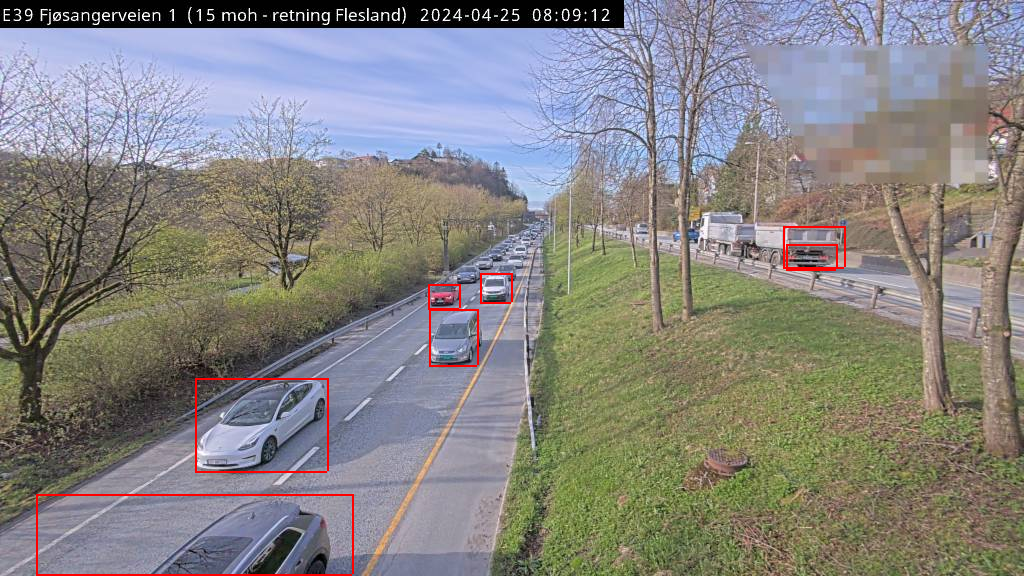

In [24]:
drawn_image = image.copy()

detections = {key:value for key,value in detections.items()}
print(detections["detection_classes"][0])

# Filter out boxes with classes and confidence > 0.5
index_list = [3, 4, 6, 8] # (cars, pickups, motorcycles, trucks)

mask = np.isin(detections["detection_classes"][0], index_list)
boxes = detections["detection_boxes"][0][mask]
scores = detections["detection_scores"][0][mask]

# Filter boxes with confidence > threshold
threshold = 0.3
boxes = boxes[scores > threshold]
scores = scores[scores > threshold]

remove_close_matches = True

if remove_close_matches:
    # Remove boxes that are too close or inside other boxes - keep the one with highest confidence
    to_remove = set()
    n = len(boxes)
    # for i in range(n):
    #     for j in range(i + 1, n):
    #         # Check if boxes are too close
    #         if np.linalg.norm(boxes[i] - boxes[j]) < 0.1:
    #             if scores[i] > scores[j]:
    #                 to_remove.add(j)
    #             else:
    #                 to_remove.add(i)

    boxes = np.delete(boxes, list(to_remove), axis=0)
    scores = np.delete(scores, list(to_remove), axis=0)

for box in boxes:
    ymin, xmin, ymax, xmax = [int(val * (image.height if i % 2 == 0 else image.width)) for i, val in enumerate(box)]
    print(xmin, ymin, xmax, ymax)

    drawn_image = np.array(drawn_image)
    drawn_image[ymin:ymax, xmin:xmin+2] = [255, 0, 0]
    drawn_image[ymin:ymax, xmax:xmax+2] = [255, 0, 0]
    drawn_image[ymin:ymin+2, xmin:xmax] = [255, 0, 0]
    drawn_image[ymax:ymax+2, xmin:xmax] = [255, 0, 0]
    drawn_image = Image.fromarray(drawn_image)

drawn_image


In [26]:
detected_classes = detections['detection_classes'][0].numpy() #guarda las clases detectadas
deteceted_scores = detections['detection_scores'][0].numpy() #guarda la puntuación  de cada predicción, para considerarla le puse que sea mayor a .50

count = 0

for i in range(len(detected_classes)):
  if detected_classes[i] in index_list and deteceted_scores[i] >= threshold: #podría ser mayor a .50 para mayor precisión
    count += 1

print(f'hay {count} vehículos en la imagen.')

hay 9 vehículos en la imagen.
